<h1 align='center'> Customers Churn Prediction

## Summary

Customer attrition is one of the important business key metrics because cost of retaining an existing customer is far less than acquiring a new one.
In this notebook, we conduct exploratory data analysis and build several machine learning models to identify customers who are at risk of churning, using bank customer data. We implement Logistic Regression, Support Vector Machine, K-Nearest Neighbors, Random Forest, and Gradient Boosting classifers and tune hyperparameters to enhance the model performance. Since our keen interest is in correctly identifying at-risk customers who make up only 20% of our sampe (data is quite imbalanced), we choose the graident boosting model that can correctly predict the churned customers. 

## Part 0. Load Libraries and Read in Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve, precision_score, recall_score, roc_auc_score

/Users/jil380/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jil380/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv("~/Desktop/projects/Customer_Churn_Prediction/Bank_Customers_Churn.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.shape

(10000, 14)

#### Data Description

## Part 1. Explore Data

In [4]:
# Turn column names into lower case
df.columns = df.columns.str.lower()

In [5]:
df.drop(['rownumber','customerid','surname'], axis=1, inplace=True)

In [6]:
# Get descriptive stats of numeric data
df.describe()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
# Check missingness
df.isnull().sum()

creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  int64  
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Geography and gender are string variables in this dataset.

In [9]:
# Check how many unique values geography variable has
df['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [10]:
# Check how many unique values gender variable has
df['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [11]:
# Gender is a binary variable. We will recreate it as numeric column
df['male'] = 0
df.loc[df.gender=='Male','male'] = 1 
df.loc[df.gender=='Female','male'] = 0
df.drop('gender', axis=1, inplace=True)
df['male'].value_counts()

1    5457
0    4543
Name: male, dtype: int64

#### Distribution of variables

In [12]:
# numeric values
df_num = df.select_dtypes(np.number)

# remove exited and male vars
df_num = df_num.iloc[:,:-2]

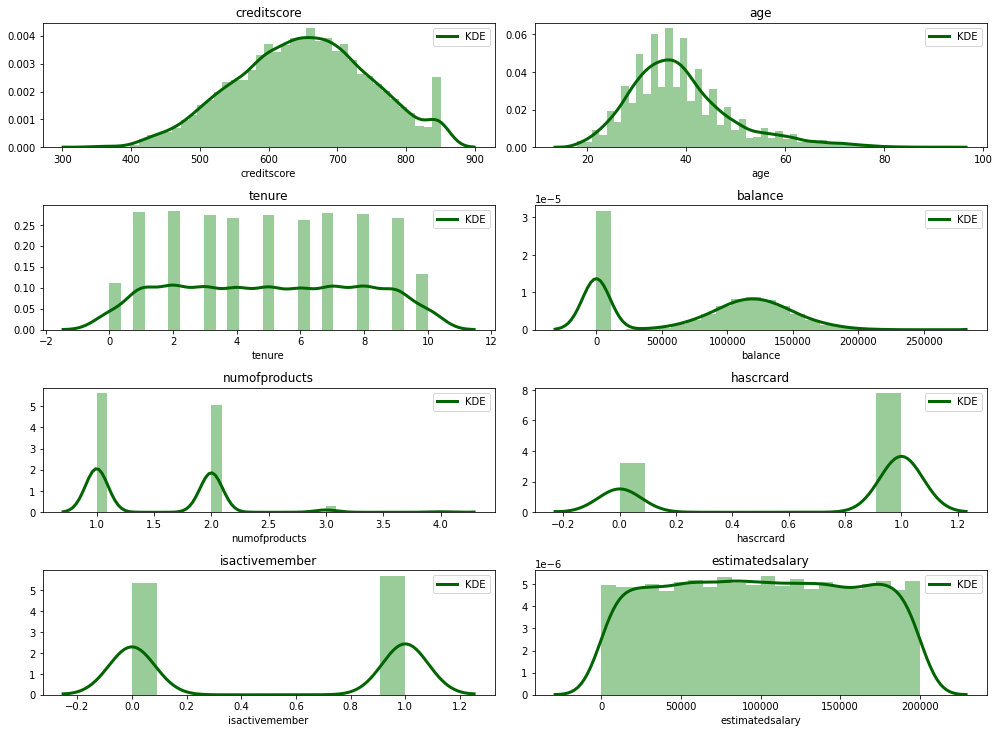

In [13]:
# Create DISTPLOT, which combines histogram and probability density plot
plt.figure(figsize=(14,20))
for i in range(len(df_num.columns)):
    plt.subplot(8, 2, i+1)
    sns.distplot(df_num[df_num.columns[i]], 
                 kde_kws={"color": "darkgreen", "lw": 3, "label": "KDE"}, 
                 hist_kws={"color": "g"})
    plt.title(df_num.columns[i])

plt.tight_layout()

- Credit Score: Given that credit scores range from 300 to 850, we see a large number of customers with a maximum score of 850. Other than the cap at 850, it seems quite normally distributed with a peak at 680.
- Age: Ages vary from late teenage to late 90s. With a peak at mid 30s, most customers are from 30-50.
- Tenure: Tenures of customers range from 0 to 10. Customers are quite equally distributed.
- Balane: We obsere two peaks. A huge number of customers have balance near 0. For others, it is normally distributed with a mean of 120,000.
- Number of Products: Most customers have 1 or 2 products, with a small proportion of customers who have 3 or 4.
- Has Credit Crad: About two-thirds of customers have a credit card. It is a binary variable.
- Is Active Member: Half of customers are active members. This is a binary variable.
- Estimated Salary: Salary is equally distributed from 0 to 200,000.

#### Target Variable - Customer Churn Indicator

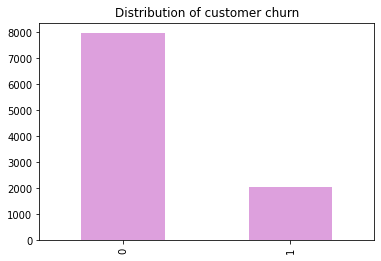

0    7963
1    2037
Name: exited, dtype: int64

In [14]:
# 'Exited' variable is the customer attrition indicator.
df['exited'].value_counts().plot(kind='bar', color='plum')
plt.title('Distribution of customer churn')
plt.show()
df['exited'].value_counts()

About 20% of customers have churned.

#### Distribution of variables by churn status

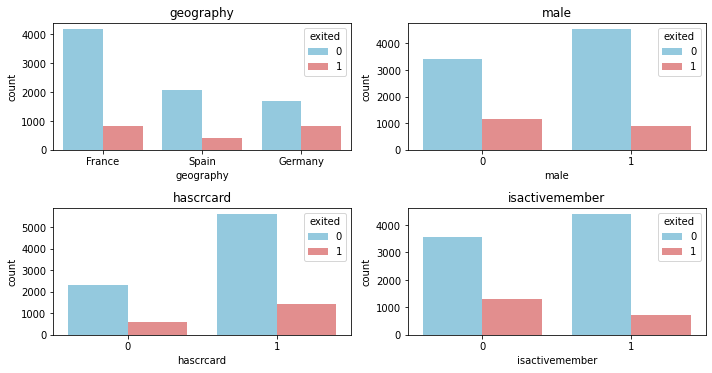

In [15]:
# Categorical Variables
df_cat = df.loc[:,['geography', 'male', 'hascrcard','isactivemember','exited']]

plt.figure(figsize=(10,10))
for i in range(len(df_cat.columns)-1):
    plt.subplot(4, 2, i+1)
    sns.countplot(x=df_cat[df_cat.columns[i]],
                 hue='exited',
                 palette = ['skyblue','lightcoral'],
                 data=df_cat)
    plt.title(df_cat.columns[i])

plt.tight_layout()

- Geography: There are a lot more customers from France but Spain and Germany seem to have bigger proportion of churned customers.
- Male: The number of male customers is greater than female customers but fewer churned customers are male.
- Credit Card: There are more customers with a credit card than not. More churned customers were also from credit card holders.
- Active Member: Unsurprisingly, there are more churned customers among inactive members. Another thing to note is that almost half of the customers are inactive members.

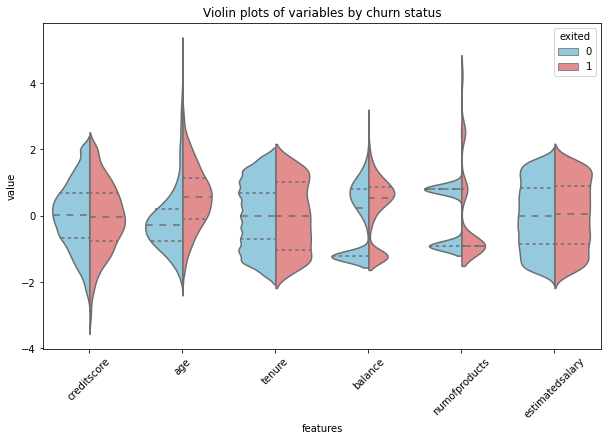

In [16]:
# Numerical variables
df_num.drop(['isactivemember','hascrcard'], axis=1, inplace=True)

# Standardize all features so that we can plot them together on one plot
df_num_std = (df_num - df_num.mean()) / (df_num.std())
dat = pd.concat([df.exited, df_num_std], axis=1)

# Unpivot dataframe 
dat = pd.melt(dat, id_vars = 'exited',  
                   var_name = 'features',
                   value_name = 'value')

# create violinplot to see 1) distributions of each variable and 2) if/how they differ by churn status
plt.figure(figsize=(10,6))
sns.violinplot(x='features', y='value', hue='exited', 
               palette = ['skyblue','lightcoral'],
               data=dat, split=True, inner='quart')
plt.xticks(rotation=45)
plt.title('Violin plots of variables by churn status');

- Credit Score: Distributions are similar between customers who churned or not.
- Age: There seems to be a significant difference in age between the churn status. Churned customers are older on average.
- Tenure: Distributions by churn status are similar.
- Balance: Churned customers have higher balance on average.
- Number of Products: A large proportion of churned customers had one product.
- Salary: Distributions by churn status are similar.

#### Correlation between variables

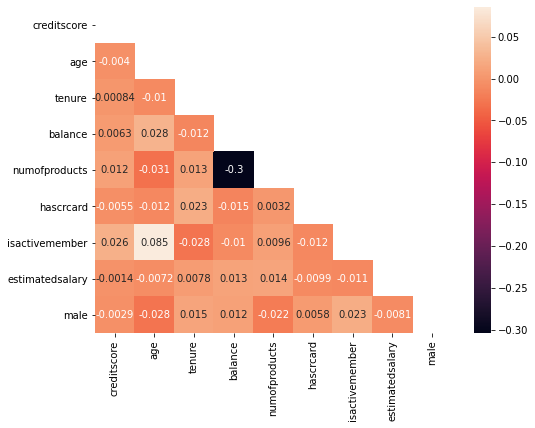

In [17]:
# Create correlation matrix
df_x = df.drop('exited', axis=1)
corr = df_x.corr()
matrix = np.triu(corr)
f, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corr, annot=True, mask=matrix)
plt.show()

There is no evidence of high corrleations between numeric variables. The biggest correlation we see here is between balance and number of products. They are negatively correlated, meaning that the more products you get, the less balance you have.

In [18]:
# Creating dummy variables for 
df = pd.get_dummies(df, columns=['geography'], prefix='geo')
df.columns = df.columns.str.lower()
df.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,male,geo_france,geo_germany,geo_spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,1,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,0,1


#### Explore Feature Importance

In [19]:
# Separate target variable
x = df.drop('exited', axis=1)
y = df['exited']

We will use random forest classifier to see which features are most important in predicting customer churn. We will revisit the random forest classifier model more in depth later.

In [20]:
# Before building models, let's explore which variables are important
rf = RandomForestClassifier(random_state=2021)
rf.fit(x, y.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=2021, verbose=0,
            warm_start=False)

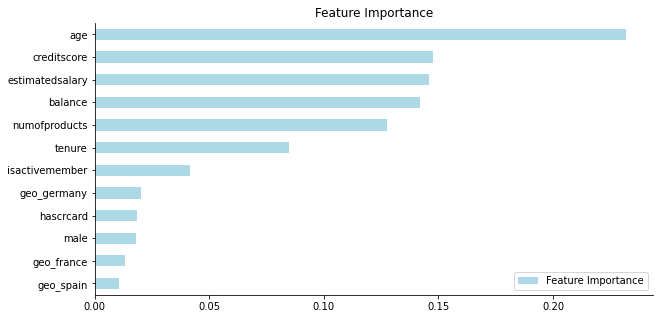

In [21]:
feat_scores = pd.DataFrame({'Feature Importance': rf.feature_importances_}, index=x.columns)
feat_scores = feat_scores.sort_values(by='Feature Importance')
feat_scores.plot(kind='barh', figsize=(10,5), color='lightblue')
plt.title('Feature Importance')
sns.despine()

Age, credit score, salary and balance seem to be most important factors for predicting customer churn.

## Part 2. Build Classification Model

In [22]:
# Split train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2021)

In [23]:
import warnings
warnings.filterwarnings('ignore')

# Scale numeric vars using StandardScaler: normalizes data to have mean 0 and sd of 1.
scaler = StandardScaler()
scale_columns = ['creditscore', 'age', 'balance', 'estimatedsalary','numofproducts','tenure']
x_train[scale_columns] = scaler.fit_transform(x_train[scale_columns])

# Apply the same sclaer for test set
x_test[scale_columns] = scaler.transform(x_test[scale_columns])

In [24]:
x_train.head(3)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,male,geo_france,geo_germany,geo_spain
6298,0.658603,1.243982,-1.038611,-1.227415,-0.906296,0,1,0.763002,0,1,0,0
3190,-0.678038,-1.032959,0.345149,0.464836,-0.906296,1,1,-1.026240,0,1,0,0
8919,0.233779,-0.653468,1.037030,0.711883,-0.906296,1,0,0.291873,1,1,0,0


### 2.0. Baseline Model

Let's calculate the accuracy when we are predicting just one prediction value for all observations.

In [25]:
print('Churned customers in training set:', y_train.mean())
print('Churned customers in testing set:', y_test.mean())

Churned customers in training set: 0.20185714285714285
Churned customers in testing set: 0.208


We see that training set has 20% of churned customers and 80% of retained customers. We can build a baseline model by predicting exited=0 for all observations and this yields about 80% accuracy for both training and testing sets. While 80% accuracy is quite decent result, this baseline model doesn't identify any churned customers. Since our goal is to identify the at-risk customers who are likely to churn so that we can put more effort to persuade them to stay with our business, we might want to build a model that is correctly predicting those at-risk customers.

### Metrics

There are several metrics to select the best model, depending on the goal of the model.

 > #### 1. Precision = TP/(TP+FP) 
Precision captures how precise your model is our of the predicted positives. This is a good metric when cost of False Positive is high. For instance, this can be used in email spam detection. If a non-spam email has been identified as spam, which is false positive, the user might lose important infromation if precision is low.   
>   
> #### 2. Recall =  TP/(TP+FN)
 Recall shows how many of the Actual Positives the model can label as Positives. This metric is useful when the cost of False Negatives is high. For example, in sick patient detection, we want to correctly identify a sick patient becuase the cost of incorrect diagnosis (False Negative) would be too high if the illness is contagious. This metric is also important in our case because we want to correctly predict at-risk customers to avoid customer churning. 
>   
> #### 3. F1 Score =  2 * (Precision * Recall) / (Precision + Recall)
F1 score is weighted harmonic mean of the precision and recall scores, that is best at 1 and worst at 0. While accuracy score can be high due to a large number of True Negatives, it put less significance on False Negatives or False Positives, which could be important in business circumstances. Therefore, F1 score can be more useful than accuracy scores when there is an uneven class distribution in data.

### 2.1. Logistic Regression

In [26]:
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn import svm

In [27]:
logreg = LogisticRegression(random_state=2021)
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2021, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
y_pred_logreg = logreg.predict(x_test)

In [29]:
print(classification_report(y_test, y_pred_logreg))

             precision    recall  f1-score   support

          0       0.82      0.97      0.89      2376
          1       0.63      0.22      0.32       624

avg / total       0.78      0.81      0.77      3000



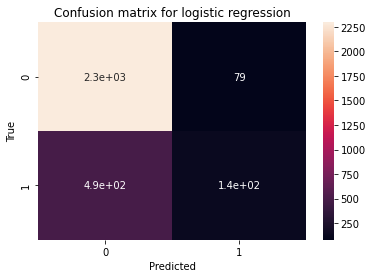

In [30]:
cm = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion matrix for logistic regression")
plt.show()

In [31]:
comparison_dict ={}
fpr, tpr, _ = roc_curve(y_test, y_pred_logreg)
comparison_dict['Logistic Regression'] = [accuracy_score(y_test, y_pred_logreg),
                           precision_score(y_test, y_pred_logreg),
                           recall_score(y_test, y_pred_logreg),
                           roc_auc_score(y_test, y_pred_logreg), fpr, tpr]

### 2.2. Support Vector Machine 

A Support Vector Machine (SVM) is a supervised learning algorithm that labels using a separating hyperplane. It chooses the optimal hyperplane that has the maximum margin, i.e, the maximum distance between data points of both classes. 

In [32]:
svm = svm.SVC(probability=True)
svm.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [33]:
y_pred_svm = svm.predict(x_test)
print(classification_report(y_test, y_pred_svm))

             precision    recall  f1-score   support

          0       0.86      0.98      0.91      2376
          1       0.83      0.37      0.51       624

avg / total       0.85      0.85      0.83      3000



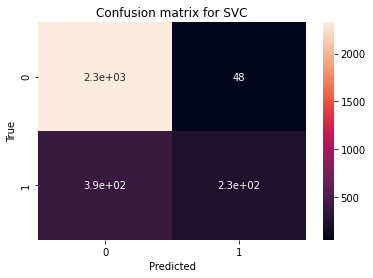

In [34]:
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion matrix for SVC")
plt.show()

In [35]:
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
comparison_dict['Support Vector Classifier'] = [accuracy_score(y_test, y_pred_svm),
                           precision_score(y_test, y_pred_svm),
                           recall_score(y_test, y_pred_svm),
                           roc_auc_score(y_test, y_pred_svm), fpr, tpr]

### 2.3. K-Nearest Neighbors Classifier

K-Nearest Neighbors is a supervised learning algorithm that labels based on similarity of features. It calculates the Euclidean distances of points and label the new data point as the dominant class among K nearest neighbors.

In [36]:
knn = KNN()
knn.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [37]:
y_pred_knn = knn.predict(x_test)
print(classification_report(y_test, y_pred_knn))

             precision    recall  f1-score   support

          0       0.86      0.94      0.90      2376
          1       0.66      0.42      0.51       624

avg / total       0.82      0.83      0.82      3000



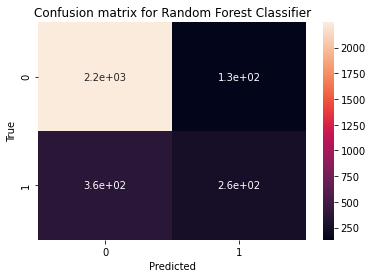

In [38]:
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion matrix for Random Forest Classifier")
plt.show()

In [39]:
fpr, tpr, _ = roc_curve(y_test, y_pred_knn)
comparison_dict['K-Nearest Neighbors'] = [accuracy_score(y_test, y_pred_knn),
                           precision_score(y_test, y_pred_knn),
                           recall_score(y_test, y_pred_knn),
                           roc_auc_score(y_test, y_pred_knn), fpr, tpr]

### 2.4. Random Forest Classifier

Random Forest Classifier is a type of ensemble algorithm. It create a set of decision trees from randomly selected subset of training data. It then combines votes from different decision tress to decide the final class of the test objects. It prevents overfitting by taking average of all the predictions

In [40]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
y_pred_rf = rf.predict(x_test)
print(classification_report(y_test, y_pred_rf))

             precision    recall  f1-score   support

          0       0.86      0.96      0.91      2376
          1       0.74      0.42      0.53       624

avg / total       0.84      0.85      0.83      3000



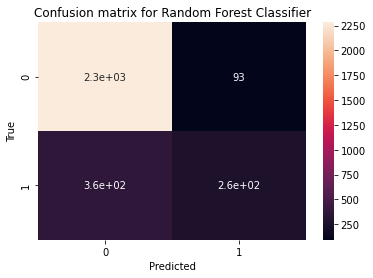

In [42]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion matrix for Random Forest Classifier")
plt.show()

In [43]:
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
comparison_dict['Random Forest'] = [accuracy_score(y_test, y_pred_rf),
                           precision_score(y_test, y_pred_rf),
                           recall_score(y_test, y_pred_rf),
                           roc_auc_score(y_test, y_pred_rf), fpr, tpr]

   ### 2.5. Gradient Boosting 

Gradient Boosting employes gradient descent algorith to minimize errors in sequential models by increaseing influence of high-performing models.

In [44]:
gb =  GradientBoostingClassifier()
gb.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [45]:
y_pred_gb = gb.predict(x_test)
print(classification_report(y_test, y_pred_gb))

             precision    recall  f1-score   support

          0       0.87      0.96      0.91      2376
          1       0.77      0.45      0.57       624

avg / total       0.85      0.86      0.84      3000



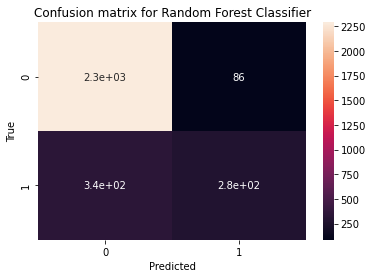

In [46]:
cm = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion matrix for Random Forest Classifier")
plt.show()

In [47]:
fpr, tpr, _ = roc_curve(y_test, y_pred_gb)
comparison_dict['Gradient Boosting'] = [accuracy_score(y_test, y_pred_gb),
                           precision_score(y_test, y_pred_gb),
                           recall_score(y_test, y_pred_gb),
                           roc_auc_score(y_test, y_pred_gb), fpr, tpr]

In [48]:
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix, index = ['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color = 'indianred', axis = 0)

,Accuracy,Precision,Recall,AUC
Logistic Regression,0.811000,0.632558,0.217949,0.592350
Support Vector Classifier,0.853000,0.827957,0.370192,0.674995
K-Nearest Neighbors,0.834667,0.664103,0.415064,0.679965
Random Forest,0.847333,0.735795,0.415064,0.687961
Gradient Boosting,0.857000,0.765668,0.450321,0.707063


Gradient Boosting has the highest accuracy, recall, and AUC. Since we want to use a model that correctly identifies customers at risk of churning, this model seems to be the best for our case.

## Part 3. Hyperparameter Tuning

We will tune hyperparameters to enhance our model. We will use GridSearchCV functions to achieve maximum recall scores. We will focus on RF and GB models since they were best performing.

#### Random Forest

from sklearn.model_selection import GridSearchCV

# Fit random forest classifier
param_grid = {'max_depth': [3, 5, 6, 7, 8], 
              'max_features': [2,4,6,7,8,9],
              'n_estimators':[50,100],
              'min_samples_split': [3, 5, 6, 7]}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, refit=True, verbose=0, scoring='recall')
rf_grid.fit(x_train,y_train)
rf_grid.best_params_

In [49]:
rf_tuned = RandomForestClassifier(max_depth=8, 
                                  max_features=9, 
                                  min_samples_split=6,
                                  n_estimators= 50)
rf_tuned.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
y_pred_rf_tuned = rf_tuned.predict(x_test)
print(classification_report(y_test, y_pred_rf_tuned))

             precision    recall  f1-score   support

          0       0.87      0.96      0.91      2376
          1       0.75      0.45      0.56       624

avg / total       0.84      0.85      0.84      3000



RF model improved after tuning the hyperparameters.

#### Gradient Boosting

# Fit Gradient boosting classifier
param_grid =  {
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
    "min_samples_leaf": [0.1, 0.5, 1],
    'max_depth': [2, 3, 5, 6, 7, 8],
    "n_estimators":[10,50,100,150]
    }
gb_grid = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, refit=True, verbose=0, scoring='recall')
gb_grid.fit(x_train,y_train)
gb_grid.best_params_

In [51]:
gb_tuned =  GradientBoostingClassifier(learning_rate=0.2,
                                       min_samples_leaf=1,
                                       max_depth=6,
                                       n_estimators=150)
gb_tuned.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [52]:
y_pred_gb_tuned = gb_tuned.predict(x_test)
print(classification_report(y_test, y_pred_gb_tuned))

             precision    recall  f1-score   support

          0       0.87      0.95      0.91      2376
          1       0.69      0.47      0.56       624

avg / total       0.83      0.85      0.84      3000



Gradient Boosting also improved as a result of hyperparameter tuning. And this model seesm to be the best model.

## Part 4. Create Precision-Recall Curve

Since we have imbalanced data, Precision-Recall curve might be more suitable than ROC curves, which can present an overly optimistic view of the model performance.
Here, we will create the PR curve for our best model, Gradient Boosting Classifier.

In [53]:
y_score_gb_tuned = gb_tuned.predict_proba(x_test)[:,-1]
average_precision = average_precision_score(y_test, y_score_gb_tuned)

In [54]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_score_gb_tuned)
gb_f1, gb_auc = f1_score(y_test, y_pred_gb_tuned), auc(recall, precision)
# summarize scores
print('Gradient Boosting: f1=%.3f auc=%.3f' % (gb_f1, gb_auc))

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

NameError: name 'f1_score' is not defined

In [ ]:
# Get accuracy scores too
from sklearn.metrics import accuracy_score
y_pred_gb_tuned = gb_tuned.predict(x_test)
accuracy_score(y_test, y_pred_gb_tuned)

## Conclusion

We can see that the gradient boosting model can correctly identify about 47% of the at-risk customers while still maintaining an overall accuracy score of 85%. This is much better than the base model that couldn't identify any at-risk customers. Using this model, we should identify customers who are likely to churn and actively engage with them via campaigns and promos. This strategy would be beneficial for our company since retaining these at-risk customers would be cheaper than acquiring new customers. 